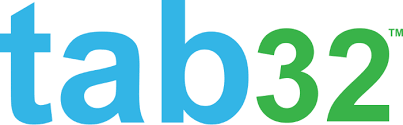

### Aim - To study the properties of 'Production' time series & its forecastability for the next two quarters.

In [1]:
import pandas as pd, tensorflow as tf, plotly.graph_objects as go, plotly.express as px, matplotlib.pyplot as plt
import pandas_datareader,warnings,seaborn as sns,numpy as np,math,datetime as dt,pmdarima,tensorflow as tf,holoviews as hv
import hvplot.pandas
from matplotlib.dates import WeekdayLocator, DateFormatter
from IPython.display import display, HTML
from sklearn import preprocessing, metrics
from pandas_datareader.data import DataReader
from itertools import cycle
from plotly.subplots import make_subplots

# Import statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.metrics import (
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    auc, 
    classification_report, 
    mean_squared_error, 
    mean_absolute_error, 
    explained_variance_score, 
    r2_score, 
    mean_poisson_deviance, 
    mean_gamma_deviance, 
    accuracy_score)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from xgboost import XGBClassifier

# Import scipy
from scipy.stats import boxcox
from scipy import stats
from scipy.signal import find_peaks

# Display
sns.set(style="whitegrid", color_codes=True)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Read data and set index as data
dataset = pd.read_csv('OneDrive - DENTINE INFORMATICS LLP/Desktop/Ledgers.csv', parse_dates = True)
dataset['ledger_date'] = pd.to_datetime(dataset.ledger_date)

clinic_id_to_name = {'64f0b7632f3bdb0027dad42d': 'Gallatin Valley Pediatric Dentistry',
    '6425169370931f001beaa4cd': 'Epic Orthodontics',
    '64250f34097f4a001a08a7c3': 'Camp Smile Pediatric Dentistry',
    '64312aa11daa0c00265192ff': 'Rallis & Bonilla Orthodontics',
    '643f8894728f4b0026fbcf83': 'Lincoln Pediatric Dentistry-N',
    '645b4ccda400ef00260afdf0': 'Kottemann Orthodontics, PLLC',
    '62adfa719123bc3764868b7f': 'Commonwealth Dental Clinic',
    '62adfb600d661bd231013b31': 'Blue Ridge Dental Group, Cbrg, PC',
    '62adf7883ad607ffbb79d6e8': 'Valley Dental',
    '62adf4dcf38e0d017b277dd0': 'Blue Ridge Dental Group Smith Mountain Lake',
    '62c0d06f6a71b71f07d1c326': 'Blue Ridge Dental Group Salem Office',
    '60dfe27720beb16201b91245': 'Triangle Family Dentistry',
    '6456c0a6acf79c5e6d0e8e66': 'ProGrin Dental and iGrin Pediatric Dentistry',
    '64290e515130aa001e9788ea': 'Sonrava, Inc. (Original)'}

# Replace clinic IDs with clinic names
dataset['clinic_id'] = dataset['clinic_id'].map(clinic_id_to_name)
dataset.rename(columns={'clinic_id': 'Clinic_Name'}, inplace=True)

In [3]:
data = dataset[dataset.category == "Production"]

In [4]:
data = data.filter(['ledger_date','Clinic_Name', 'debit_src'])
data['ledger_date'] = pd.to_datetime(data.ledger_date)
data.set_index('ledger_date', inplace = True)
data.dropna(inplace=True)

# Clinical Productions

In [5]:
prod = data.pivot_table(index='ledger_date', columns='Clinic_Name', values='debit_src', aggfunc='sum')
prod.reset_index(inplace=True)
prod.fillna(0, inplace=True)
prod.columns.name = None
prod.set_index('ledger_date', inplace = True)

In [6]:
provider = dataset.pivot_table(index='ledger_date', columns='provider_name', values='debit_src', aggfunc='sum')
provider.reset_index(inplace=True)
provider.fillna(0, inplace=True)
provider.columns.name = None
provider.set_index('ledger_date', inplace = True)

# Procedure Production

In [7]:
proc = dataset.pivot_table(index='ledger_date', columns='proc_code', values='debit_src', aggfunc='sum')
proc.reset_index(inplace=True)
proc.fillna(0, inplace=True)
proc.columns.name = None
proc.set_index('ledger_date', inplace = True)

# Production at a Patient level

In [8]:
pat = dataset.pivot_table(index='ledger_date', columns='Is_NewPatient', values='debit_src', aggfunc='sum')
pat.reset_index(inplace=True)
pat.fillna(0, inplace=True)
pat.columns.name = None
pat.set_index('ledger_date', inplace = True)

In [9]:
clinic_returns = prod.pct_change()
proc_returns = proc.pct_change()
pat_returns = pat.pct_change()
provider_returns = provider.pct_change()

### Plot the daily Production at a Clinical Level

In [10]:
# num_clinics = len(prod.columns)
# num_rows = math.ceil(num_clinics / 2)  # Use 2 columns per row
# fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, 3 * num_rows))

# # Plot daily returns for each clinic
# for i, clinic_name in enumerate(prod.columns):
#     ax_row = i // 2
#     ax_col = i % 2
#     prod[clinic_name].plot(ax=axes[ax_row, ax_col], legend=True)
#     axes[ax_row, ax_col].set_title(clinic_name)

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()

### Plot the daily Production at a Procedure Level

In [11]:
# num_proc = len(proc.columns)
# num_rows = math.ceil(num_proc / 2)  # Use 2 columns per row
# fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, 3 * num_rows))
# for i, proc_name in enumerate(proc.columns):
#     ax_row = i // 2
#     ax_col = i % 2
#     proc[proc_name].plot(ax=axes[ax_row, ax_col], legend=True)
#     axes[ax_row, ax_col].set_title(proc_name)
# plt.tight_layout()
# plt.show()

### Plot the daily return percentage at Procedure Level

In [12]:
# num_proc = len(proc_returns.columns)
# num_rows = math.ceil(num_proc / 2)  # Use 2 columns per row
# fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, 3 * num_rows))
# for i, proc_name in enumerate(proc_returns.columns):
#     ax_row = i // 2
#     ax_col = i % 2
#     proc_returns[proc_name].plot(ax=axes[ax_row, ax_col], legend=True)
#     axes[ax_row, ax_col].set_title(proc_name)
# plt.tight_layout()
# plt.show()

In [13]:
# sns.pairplot(pat_returns, kind='reg')

# Correlations between clinics, procedures and other

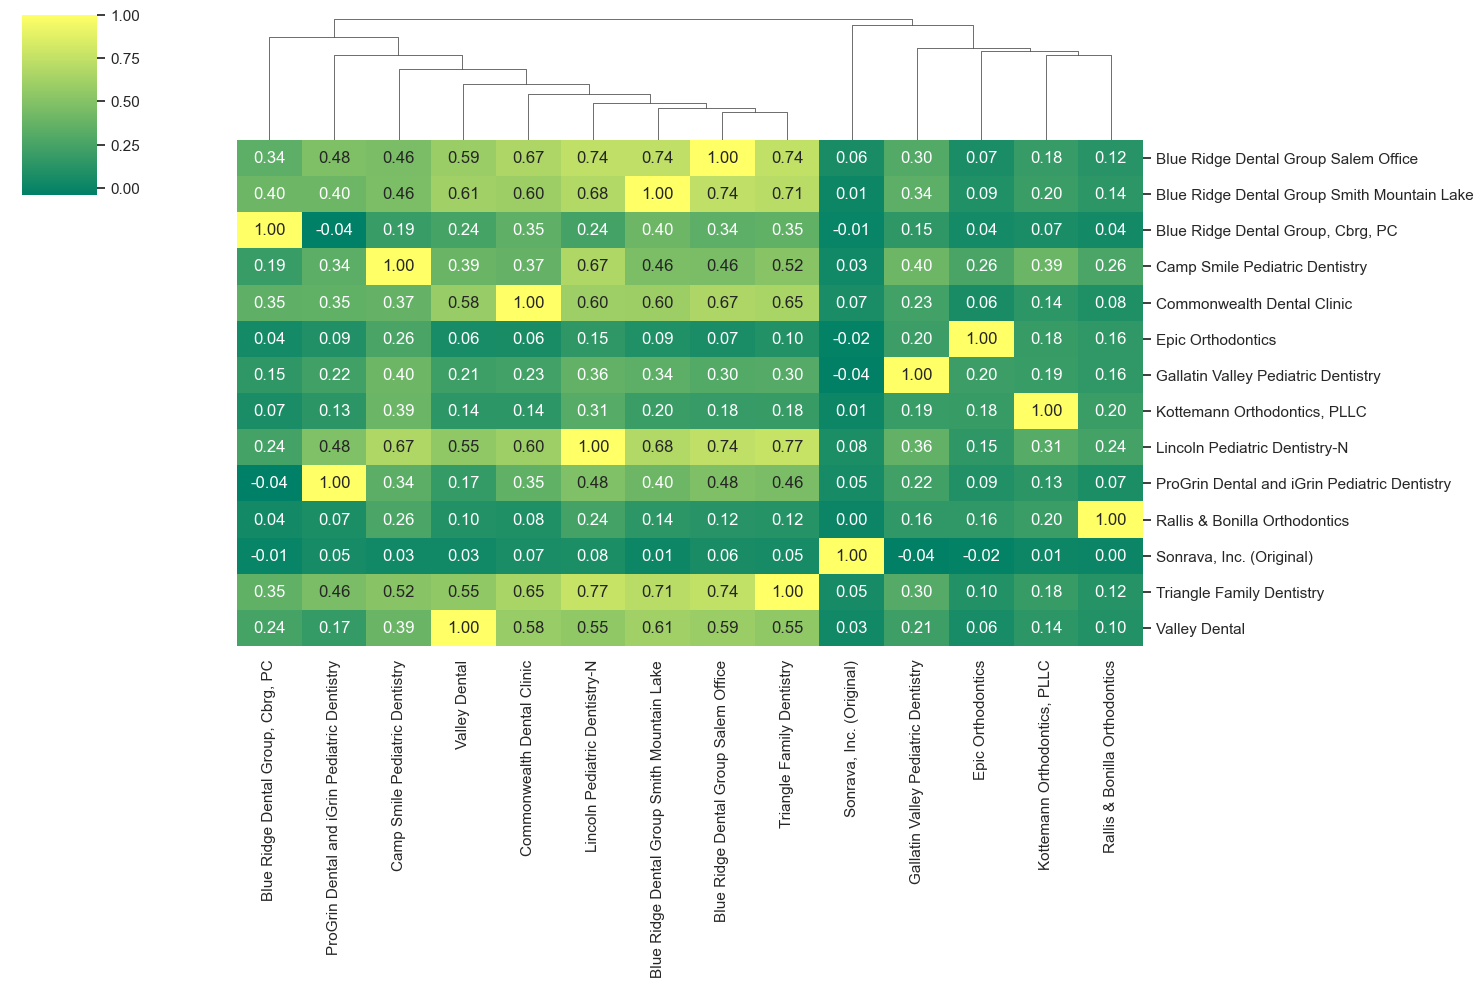

In [14]:
sns.clustermap(prod.corr(), annot=True, cmap='summer', fmt=".2f", 
               row_cluster=False, figsize=(15,10))
plt.show()

In [15]:
correlation_matrix = prod.corr()
def generate_correlation_report(correlation_matrix, threshold=0.5):
    report = []
    processed_pairs = set()

    for col1 in correlation_matrix.columns:
        for col2 in correlation_matrix.columns:
            if col1 != col2:
                if (col1, col2) not in processed_pairs and (col2, col1) not in processed_pairs:
                    correlation = correlation_matrix.loc[col1, col2]
                    if abs(correlation) >= threshold:
                        report.append((col1, col2, correlation))
                    processed_pairs.add((col1, col2))

    if not report:
        report.append(("No strong correlations found", "", 0.0))

    return report

# Call the function with your correlation matrix
correlation_report = generate_correlation_report(correlation_matrix, threshold=0.7)

# Convert the report list into a DataFrame
df = pd.DataFrame(correlation_report, columns=['Process 1', 'Process 2', 'Correlation Coefficient'])

df

,Process 1,Process 2,Correlation Coefficient
0,Blue Ridge Dental Group Salem Office,Blue Ridge Dental Group Smith Mountain Lake,0.736472
1,Blue Ridge Dental Group Salem Office,Lincoln Pediatric Dentistry-N,0.736563
2,Blue Ridge Dental Group Salem Office,Triangle Family Dentistry,0.742946
3,Blue Ridge Dental Group Smith Mountain Lake,Triangle Family Dentistry,0.710290
4,Lincoln Pediatric Dentistry-N,Triangle Family Dentistry,0.769988


In [16]:
correlation_matrix = proc.corr()

# Define a function to generate a correlation report
def generate_correlation_report(correlation_matrix, threshold=0.5):
    report = []

    for col1 in correlation_matrix.columns:
        for col2 in correlation_matrix.columns:
            if col1 != col2:
                correlation = correlation_matrix.loc[col1, col2]
                if abs(correlation) >= threshold:
                    report.append((col1, col2, correlation))

    if not report:
        report.append(("No strong correlations found", "", 0.0))

    return report

# Call the function with your correlation matrix
correlation_report = generate_correlation_report(correlation_matrix, threshold=0.9)

# Convert the report list into a DataFrame
df = pd.DataFrame(correlation_report, columns=['Column 1', 'Column 2', 'Correlation'])

# Print the DataFrame
df

,Column 1,Column 2,Correlation
0,Diagnostic,Preventative,0.918517
1,Diagnostic,Preventive,0.929643
2,Diagnostic,Restorative,0.949106
3,Preventative,Diagnostic,0.918517
4,Preventive,Diagnostic,0.929643
5,Preventive,Restorative,0.944767
6,Restorative,Diagnostic,0.949106
7,Restorative,Preventive,0.944767


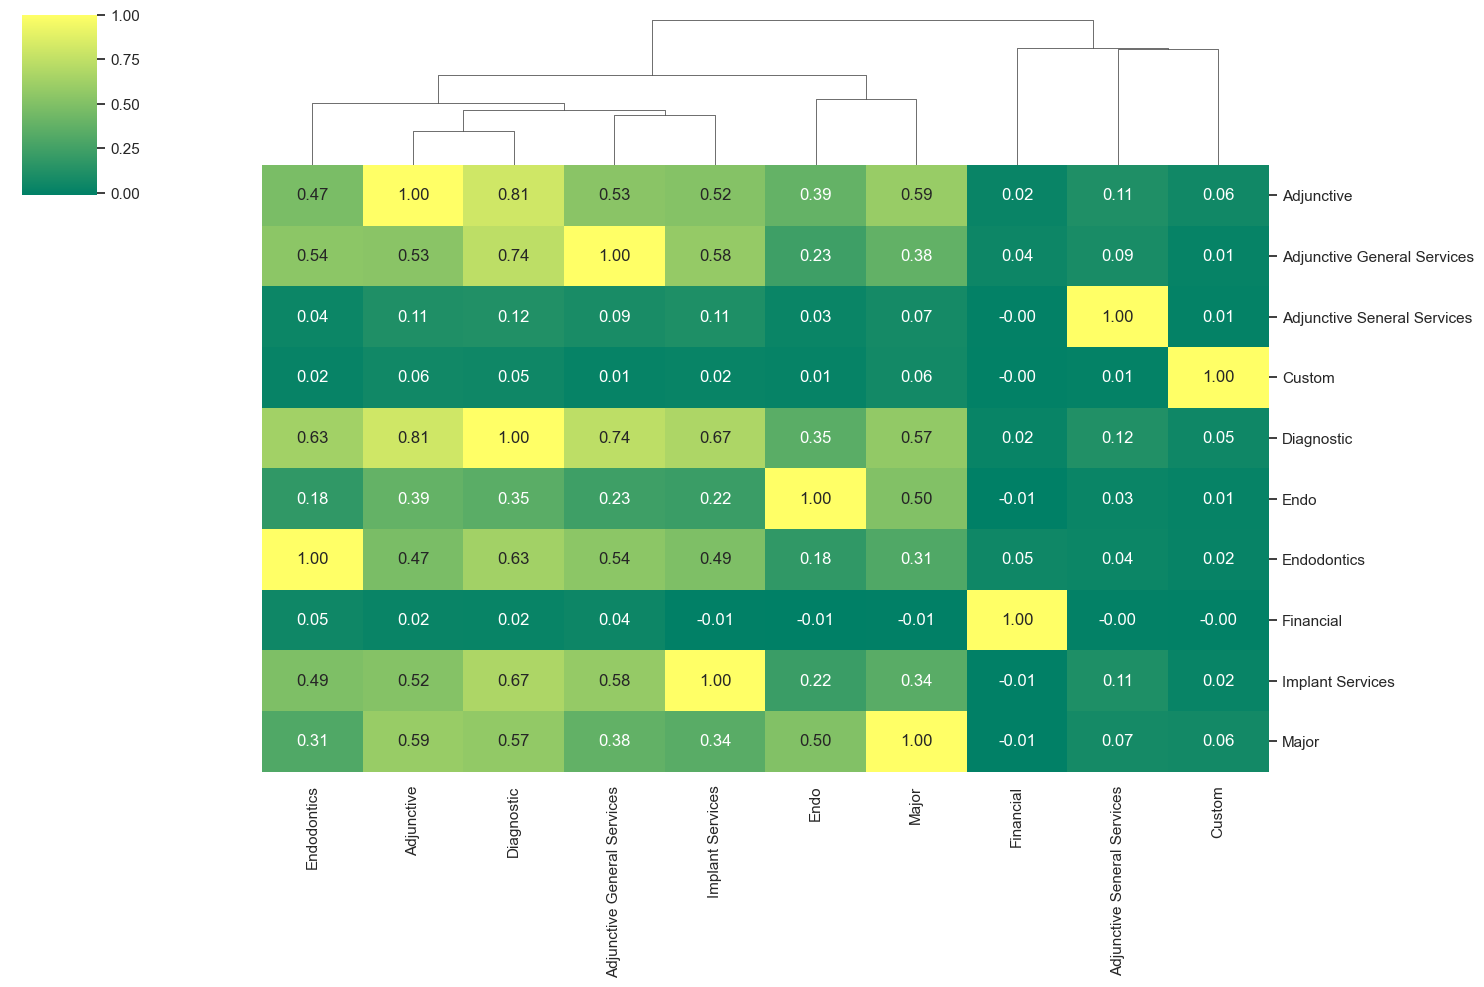

In [17]:
sns.clustermap(proc.iloc[:, :10].corr(), annot=True, cmap='summer', fmt=".2f", 
               row_cluster=False, figsize=(15,10))
plt.show()

In [18]:
# plt.figure(figsize=(25, 15))
# plt.subplot(2, 2, 1)
# sns.heatmap(provider_returns.iloc[:, :10].corr(), annot=True, cmap='summer')
# plt.title('Correlation of provider Productions Returns')
# plt.subplot(2, 2, 2)
# sns.heatmap(provider.iloc[:, :10].corr(), annot=True, cmap='summer')
# plt.title('Correlation of provider Productions')

### Moving averages for Process level production 

In [19]:
# ma_periods = [10, 20, 30]
# ma_df = pd.DataFrame()  # Create a new DataFrame for moving averages

# for column in proc.columns:
#     for period in ma_periods:
#         ma_column = f'{column}_MA_{period}'
#         ma_df[ma_column] = proc[column].rolling(window=period).mean()

# # Plot the original data along with the moving averages
# num_proc = len(proc.columns)
# num_rows = math.ceil(num_proc / 2)  # Use 2 columns per row
# fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, 3 * num_rows))
# for i, column in enumerate(proc.columns):
#     ax_row = i // 2
#     ax_col = i % 2
#     proc[column].plot(ax=axes[ax_row, ax_col], legend=True, label='Original')
#     axes[ax_row, ax_col].set_title(column)
#     for period in ma_periods:
#         ma_column = f'{column}_MA_{period}'
#         ma_df[ma_column].plot(ax=axes[ax_row, ax_col], legend=True, label=f'{period}-period MA')
#     axes[ax_row, ax_col].legend()
# plt.tight_layout()
# plt.show()

### Moving Average for periods 10, 20 and 50 days for Production

In [20]:
data.drop('Clinic_Name', axis = 1, inplace = True) # gross Production

## Forecasting

In [21]:
data = data.resample('W').sum()

### Time series Split

In [22]:
train = data[:-(5 * 12)]
test = data[-(5 * 12):]

### Normal Split

In [23]:
# train = data[:int(len(data) * 0.8)]
# test = data[int(len(data) * 0.8):]

In [24]:
summary_period = 24     # 12 months
ref_mean = np.mean(train[-summary_period:].values)
ref_std = np.std(train[:-summary_period].values)

one_std_bands = (ref_mean - ref_std, ref_mean + ref_std)
two_std_bands = (ref_mean - (2 * ref_std), ref_mean + (2 * ref_std))
three_std_bands = (ref_mean - (3 * ref_std), ref_mean + (3 * ref_std))

# ax, fig = plt.subplots(figsize = (15, 5))
# plt.plot(train, label = "Training", color = '#7b57cb')
# plt.plot(test, label = "Testing", color = '#009ca6')
# plt.axhline(y = one_std_bands[0], color = "#262626", linestyle = "dotted", label = "1 s.d.")
# plt.axhline(y = one_std_bands[1], color = "#262626", linestyle = "dotted")
# plt.axhline(y = two_std_bands[0], color = "#FF8A3D", linestyle = "dotted", label = "2 s.d.")
# plt.axhline(y = two_std_bands[1], color = "#FF8A3D", linestyle = "dotted")
# plt.axhline(y = three_std_bands[0], color = "#D62598", linestyle = "dotted", label = "3 s.d.")
# plt.axhline(y = three_std_bands[1], color = "#D62598", linestyle = "dotted")
# plt.legend(loc = 'best', fontsize = (13))
# plt.xlabel("Date", fontsize = (20))
# plt.ylabel("Production Balance", fontsize = (20))
# plt.title("Forecasting Production", fontsize = 20)
# plt.show()

# ETS

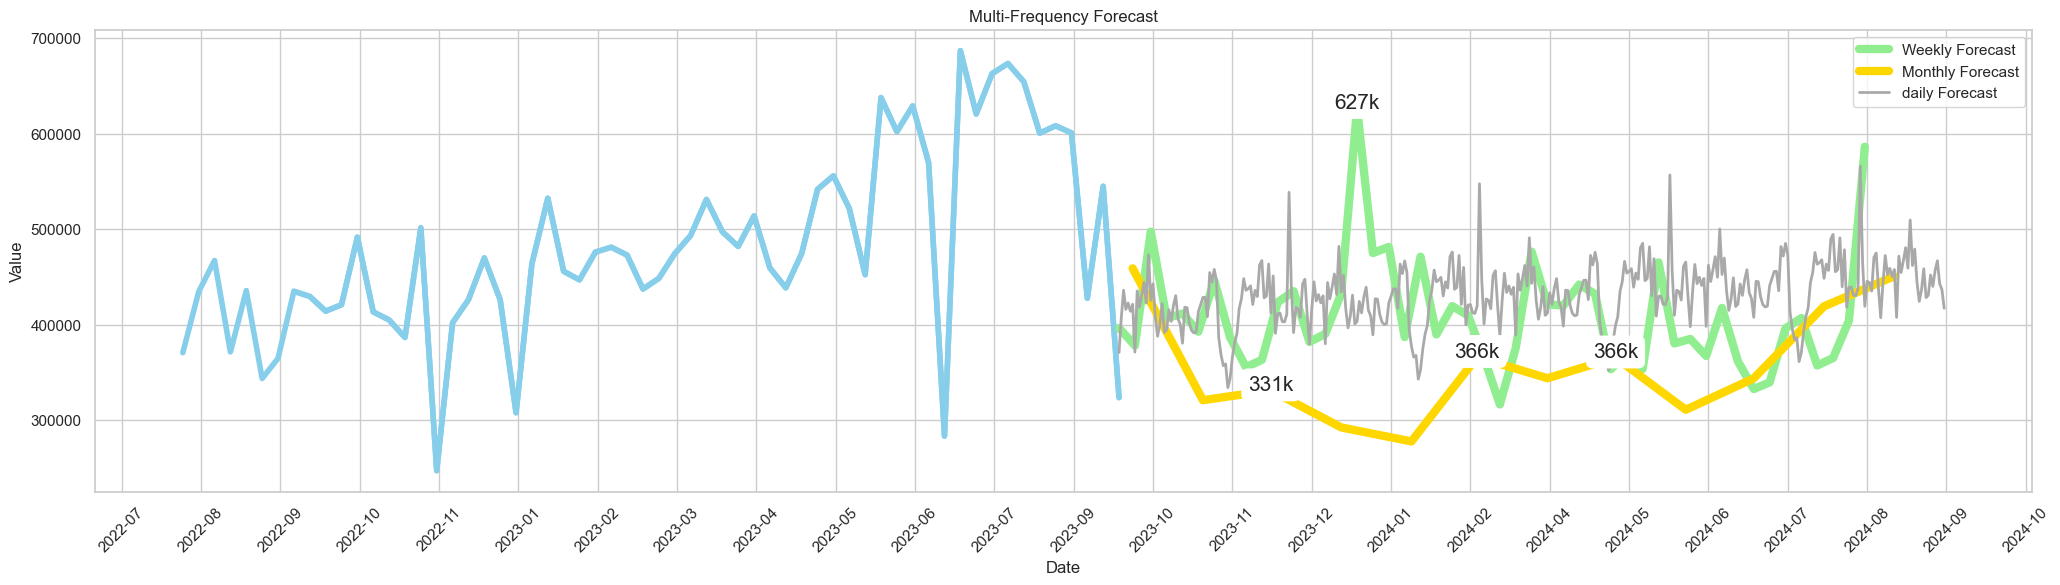

In [25]:
#Daily 
model_daily = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=84).fit()
forecast_daily = model_daily.forecast(steps=365)

# Weekly Forecast
model_weekly = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=32).fit()
forecast_weekly = model_weekly.forecast(steps=48)

# Monthly Forecast
model_monthly = ExponentialSmoothing(train.resample('M').mean(),trend='mul',seasonal='mul',seasonal_periods=12).fit()
forecast_monthly = model_monthly.forecast(steps=12)

# Create the forecast indices for weekly, monthly, and daily forecasts
forecast_index_weekly = pd.date_range(start=test.index[-1], periods=48, freq='W')
forecast_index_monthly = pd.date_range(start=test.index[-1], periods=12, freq='M')
forecast_index_daily = pd.date_range(start=test.index[-1], periods=365, freq='D')

# Filter data for plotting starting from 2021
plot_start_date = (test.index[-1] - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
training = data[data.index >= plot_start_date]
plt.figure(figsize=(25, 6))

# Modify the peak detection part to find peaks for both weekly and monthly forecasts
peaks_monthly, _ = find_peaks(forecast_monthly)
peaks_weekly, _ = find_peaks(forecast_weekly)

# Calculate a threshold for labeling only the highest peaks
peak_threshold_monthly = 0.70 * max(forecast_monthly)  # Adjust the threshold as needed
peak_threshold_weekly = 0.80 * max(forecast_weekly)  # Adjust the threshold as needed

# Filter the peaks to select only the highest ones
highest_peaks_monthly = [p for p in peaks_monthly if forecast_monthly[p] >= peak_threshold_monthly]
highest_peaks_weekly = [p for p in peaks_weekly if forecast_weekly[p] >= peak_threshold_weekly]

label_distance = 20  # Distance above the peaks to place labels

def format_label(value):
    if value >= 1000:
        return f'{int(round(value / 1000))}k'
    return f'{int(round(value))}'

for peak in highest_peaks_monthly:
    forecast_value = forecast_monthly[peak]
    label = f'{format_label(forecast_value)}'
    plt.annotate(label, (forecast_index_monthly[peak], forecast_value + label_distance),
                 textcoords="offset points", xytext=(0, 0), ha='center', fontsize=15,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white'))

for peak in highest_peaks_weekly:
    forecast_value = forecast_weekly[peak]
    label = f'{format_label(forecast_value)}'
    plt.annotate(label, (forecast_index_weekly[peak], forecast_value + label_distance),
                 textcoords="offset points", xytext=(0, 0), ha='center', fontsize=15,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white'))
    
plt.plot(training.index, training, test.index, test, color='skyBlue', linewidth=4)
plt.plot(forecast_index_weekly, forecast_weekly, label='Weekly Forecast', color='lightgreen', linewidth=6)
plt.plot(forecast_index_monthly, forecast_monthly, label='Monthly Forecast', color='gold', linewidth=6)
plt.plot(forecast_index_daily, forecast_daily, label='daily Forecast', color='darkgrey', linewidth=2)
plt.legend(loc='best')
plt.title('Multi-Frequency Forecast')
plt.xlabel('Date')
plt.ylabel('Value')

# Set the major ticks on the x-axis at weekly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=0, interval=5))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()

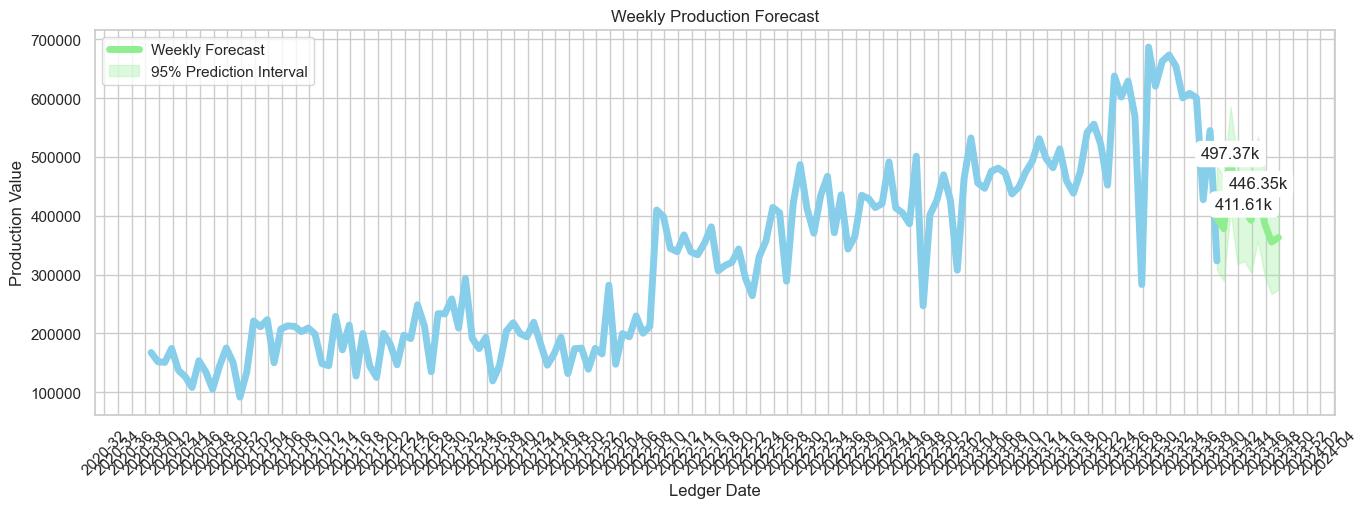

In [26]:
# Fit an auto-ETS model
model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=32).fit()
forecast = model.forecast(steps=20)

# Create the forecast index
forecast_index = pd.date_range(start=test.index[-1], periods=20, freq='W')
plot_start_date = (test.index[-1] - pd.DateOffset(years=2)).strftime('%Y-%m-%d')
training = data[data.index >= plot_start_date]
peaks, _ = find_peaks(forecast)

# Calculate a threshold for labeling only the highest peaks
peak_threshold = 0.60 * max(forecast)  # Adjust the threshold as needed

# Filter the peaks to select only the highest ones
highest_peaks = [p for p in peaks if forecast[p] >= peak_threshold]

label_distance = 20  # Distance above the peaks to place labels
forecast_index = forecast_index[:len(forecast)]

# Calculate prediction intervals manually
forecast_stderr = model.sse / (len(train) - 2)
z = 1.96  # 95% prediction interval (adjust as needed)
lower_bound = forecast - z * np.sqrt(forecast_stderr)
upper_bound = forecast + z * np.sqrt(forecast_stderr)

plt.figure(figsize=(16, 5))

def format_label(value):
    if value >= 1000000:
        return f'{value / 1000000:.2f}m'
    elif value >= 1000:
        return f'{value / 1000:.2f}k'
    return f'{value:.2f}'

for peak in highest_peaks:
    forecast_value = forecast[peak]
    label = f'{format_label(forecast_value)}'
    plt.annotate(label, (forecast_index[peak], forecast_value + label_distance),
                 textcoords="offset points", xytext=(0, 0), ha='center', fontsize=12,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white'))
                 
plt.plot(training.index, training, color='skyblue', linewidth=5)
plt.plot(test.index, test, color='skyblue')
plt.plot(forecast_index, forecast, label='Weekly Forecast', color='lightgreen', linewidth=5)
plt.fill_between(forecast_index, lower_bound, upper_bound, color='lightgreen', alpha=0.3, label='95% Prediction Interval')
plt.legend(loc='best')
plt.title('Weekly Production Forecast')
plt.xlabel('Ledger Date')
plt.ylabel('Production Value')

def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'
ax = plt.gca()
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=0, interval=5))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%W"))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()

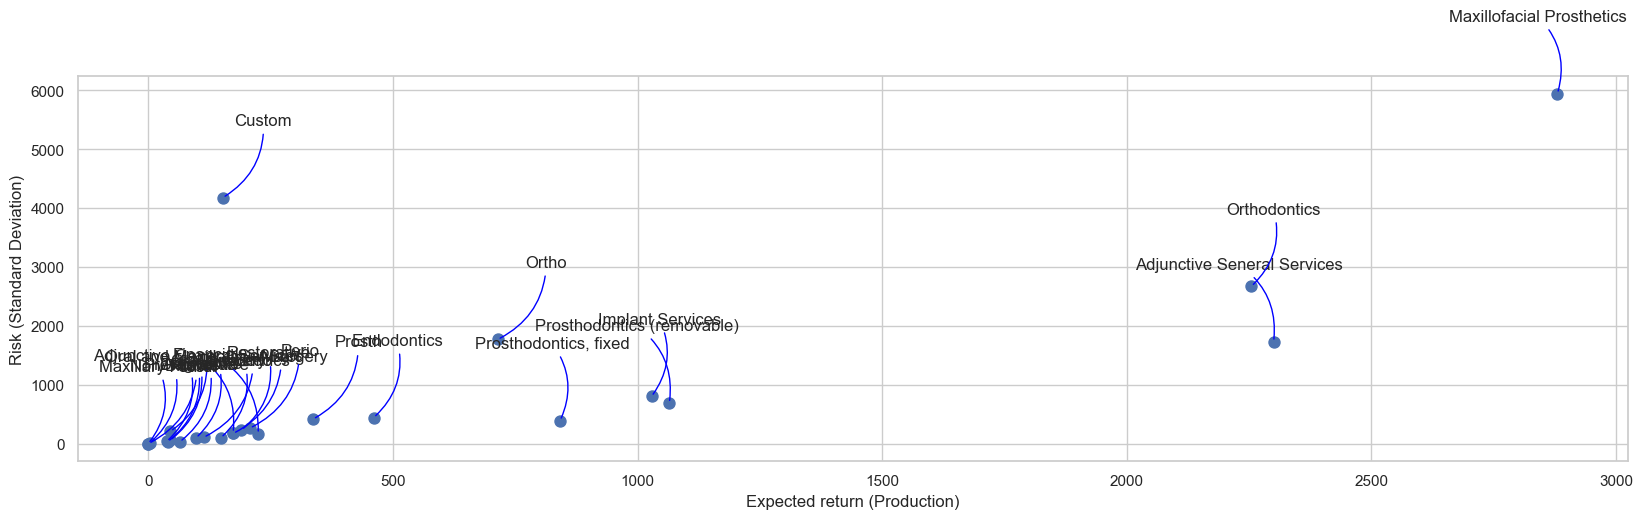

In [27]:
returns = dataset.groupby('proc_code')['debit_src'].mean()
risk = dataset.groupby('proc_code')['debit_src'].std()

# Adjust the size of the points
area = np.pi * 20

# Create the scatter plot
plt.figure(figsize=(20, 5))
plt.scatter(returns, risk, s=area)
plt.xlabel('Expected return (Production)')
plt.ylabel('Risk (Standard Deviation)')

# Annotate points with clinic IDs
for label, x, y in zip(returns.index, returns, risk):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

plt.show()

In [28]:
# Time Series Cross-Validation (Walk-Forward Validation)
# Time Series K-Fold Cross-Validation
# Rolling Origin Validation
# Expanding Window Validation

### Facebook Prophet Analysis

In [31]:
dataset = pd.read_csv('OneDrive - DENTINE INFORMATICS LLP/Desktop/Ledgers.csv', parse_dates = True)
dataset['ledger_date'] = pd.to_datetime(dataset.ledger_date)
data = dataset[dataset.category == "Production"]
data = data.filter(['ledger_date','debit_src'])
data = data.rename(columns={'ledger_date':'ds', 'debit_src':'y'})

In [33]:
last = data[len(data)-1:]
data = data[:-1]
from prophet.forecaster import Prophet
fbp = Prophet(daily_seasonality = True)

In [ ]:
fbp.fit(df1)
future = fbp.make_future_dataframe(periods=10)
forecast = fbp.predict(future)

13:28:42 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
import prophet.forecaster
from prophet.plot import plot_plotly
from prophet.forecaster import plot, plot_components
plot_plotly(fbp, forecast)